In [1]:
from common.env.procgen_wrappers import *
from common.logger import Logger
from common.storage import Storage
from common.model_target import NatureModel, ImpalaModelTarget
from common.policy import CategoricalPolicy
from common import set_global_seeds, set_global_log_levels

import os, time, yaml, argparse
import gym
from procgen import ProcgenEnv
import random
import torch

import matplotlib.pyplot as plt

device = torch.device('cuda')

In [9]:
exp_name = "test_exp"
env_name = "coinrun"
start_level = 0
num_levels = 0
distribution_mode = "easy"
param_name = "easy-200"
device = "cuda"
gpu_device = 0
num_timesteps = 1
seed = 42
log_level = 40
num_checkpoints = 0

set_global_seeds(seed)
set_global_log_levels(log_level)

####################
## HYPERPARAMETERS #
####################
print('[LOADING HYPERPARAMETERS...]')
with open('hyperparams/procgen/config.yml', 'r') as f:
    hyperparameters = yaml.safe_load(f)[param_name]
for key, value in hyperparameters.items():
    print(key, ':', value)

############
## DEVICE ##
############
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_device)
device = torch.device('cuda')

#################
## ENVIRONMENT ##
#################
print('INITIALIZAING ENVIRONMENTS...')
n_steps = hyperparameters.get('n_steps', 256)
n_envs = 4
# By default, pytorch utilizes multi-threaded cpu
# Procgen is able to handle thousand of steps on a single core

game_asset_idx = [1, 5, 10, 16] #[2 for _ in range(n_envs)]

torch.set_num_threads(4)
env = ProcgenEnv(num_envs=n_envs,
                env_name=env_name,
                start_level=start_level,
                num_levels=num_levels,
                distribution_mode=distribution_mode,
                game_asset_index=game_asset_idx,
                is_test=False, #True,
                render_mode="rgb_array",
            )
normalize_rew = hyperparameters.get('normalize_rew', True)
env = VecExtractDictObs(env, "rgb")
if normalize_rew:
    env = VecNormalize(env, ob=False) # normalizing returns, but not the img frames.
env = TransposeFrame(env)
env = ScaledFloatFrame(env)

############
## LOGGER ##
############
print('INITIALIZAING LOGGER...')
logdir = 'procgen/' + env_name + '/' + exp_name + '/' + 'seed' + '_' + \
            str(seed) + '_' + time.strftime("%d-%m-%Y_%H-%M-%S")
logdir = os.path.join('logs', logdir)
if not (os.path.exists(logdir)):
    os.makedirs(logdir)
logger = Logger(n_envs, logdir)

###########
## MODEL ##
###########
print('INTIALIZING MODEL...')
observation_space = env.observation_space
observation_shape = observation_space.shape
architecture = hyperparameters.get('architecture', 'impala')
in_channels = observation_shape[0]
action_space = env.action_space

# Model architecture
if architecture == 'nature':
    model = NatureModel(in_channels=in_channels)
elif architecture == 'impala':
    model = ImpalaModelTarget(in_channels=in_channels)

[LOADING HYPERPARAMETERS...]
algo : ppo
n_envs : 128
n_steps : 256
epoch : 3
mini_batch_per_epoch : 8
mini_batch_size : 4096
gamma : 0.999
lmbda : 0.95
learning_rate : 8e-05
grad_clip_norm : 0.5
eps_clip : 0.2
value_coef : 0.5
entropy_coef : 0.01
normalize_adv : True
normalize_rew : True
use_gae : True
architecture : impala
recurrent : False
INITIALIZAING ENVIRONMENTS...
INITIALIZAING LOGGER...
INTIALIZING MODEL...


In [10]:
obs = env.reset()

In [11]:
obs.shape

(4, 3, 128, 128)

In [7]:
import einops

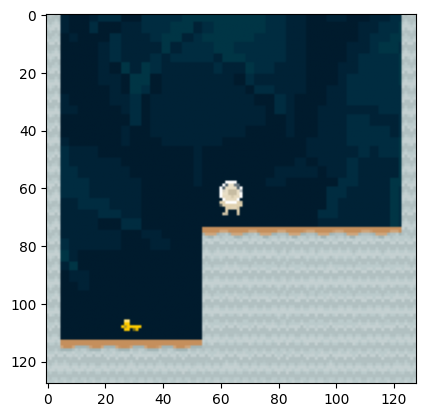

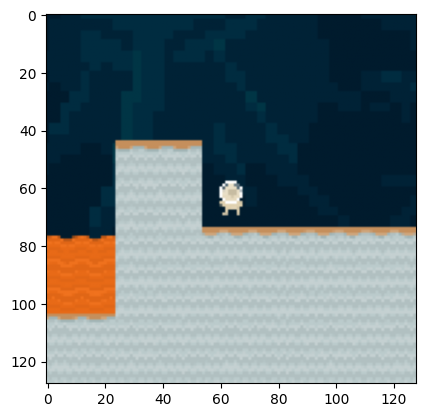

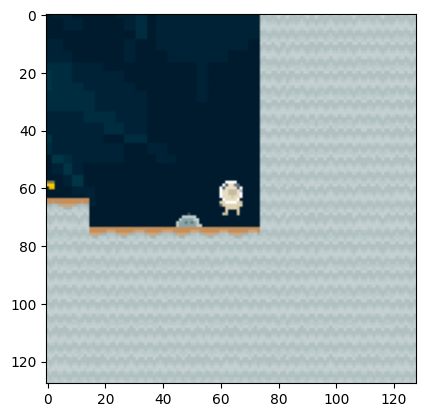

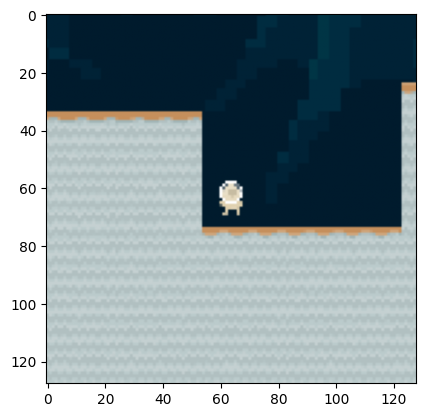

In [12]:
obs = einops.rearrange(obs, "b c w h -> b w h c")

for i in range(4):
    plt.imshow(obs[i])
    plt.show()

In [ ]:

# Discrete action space
recurrent = hyperparameters.get('recurrent', False)
if isinstance(action_space, gym.spaces.Discrete):
    action_size = action_space.n
    policy = CategoricalPolicy(model, recurrent, action_size)
else:
    raise NotImplementedError
policy.to(device)

#############
## STORAGE ##
#############
print('INITIALIZAING STORAGE...')
hidden_state_dim = model.output_dim
storage = Storage(observation_shape, hidden_state_dim, n_steps, n_envs, device)

###########
## AGENT ##
###########
print('INTIALIZING AGENT...')
algo = hyperparameters.get('algo', 'ppo')
if algo == 'ppo':
    from agents.ppo import PPO as AGENT
else:
    raise NotImplementedError
agent = AGENT(env, policy, logger, storage, device, game_asset_idx, num_checkpoints, is_test=True, **hyperparameters)

In [ ]:
agent.policy.load_state_dict(torch.load("/home/qfeuilla/Desktop/Explicit_Goal_Pointer/EGPWorkBench/logs/procgen/coinrun/easy-random-100-res-128-coins-27/seed_5917_07-12-2022_00-52-12/model_44007424.pth")["state_dict"])

In [ ]:
from IPython.display import clear_output

obs = agent.env.reset()
hidden_state = np.zeros((agent.n_envs, agent.storage.hidden_state_size))
done = np.zeros(agent.n_envs)

while not done[0]:
    agent.policy.eval()
    act, _, _, nh = agent.predict(obs, hidden_state, done, agent.goal_targets)
    no, r, done, _ = agent.env.step(act)

    obs = no
    hidden_state = nh